# TOY PROJECT 07. Color the sketch

## 1. Load Libraries

In [35]:
import os
import time
import datetime
import random

import cv2
import numpy as np
import tensorflow as tf


from matplotlib import pyplot as plt


In [16]:
def imshow_compare(original, changed):
    plt.figure(figsize=(10,4))
    
    plt.subplot(121)
    plt.imshow(original)
    
    plt.subplot(122)
    plt.imshow(changed)
    
    plt.show()
    

## 2. Load and check the dataset


In [3]:
dir_dataset = os.getcwd() + '/data/cityscapes'
dir_train = dir_dataset + '/train/'
data_train = os.listdir(dir_train)

len(data_train)


1000

(256, 512, 3)


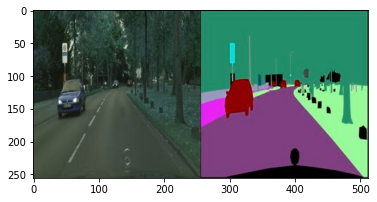

In [4]:
sample = dir_train + data_train[0]
image = cv2.imread(sample)

plt.imshow(image)
print(image.shape)


In [6]:
## Need to split images up into 2 pieces
labels = []; sketches = []

for image in data_train:
    origin = cv2.imread(dir_train + image)
    num_div = origin.shape[1] // 2
    label, sketch = origin[:, :num_div, :], origin[:, num_div:, :]
    
    labels.append(label)
    sketches.append(sketch)

len(labels), len(sketches)


(1000, 1000)

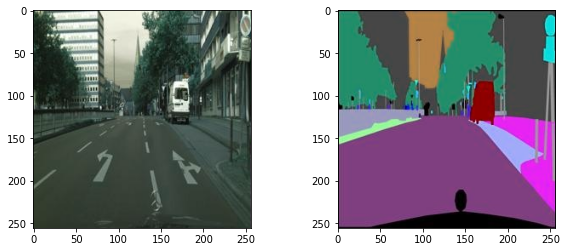

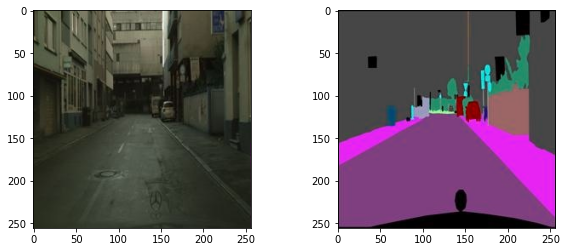

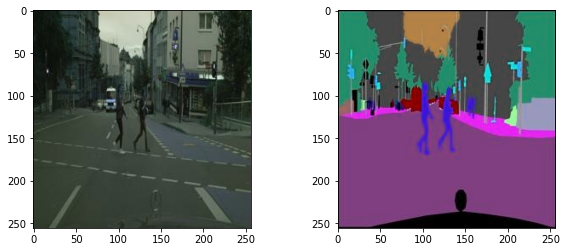

In [32]:
# Check the separated images

for i in range(3):
    idx = random.randint(0, len(labels))
    
    imshow_compare(labels[idx], sketches[idx])


## 3. Data Augmentation
Read the article introducing simple ways of augmentations.  
(https://towardsdatascience.com/complete-image-augmentation-in-opencv-31a6b02694f5)

Used these three methods
1. Channel Shift
2. Horizontal Flip
3. Rotation

### 3.1. Test Augmentation 

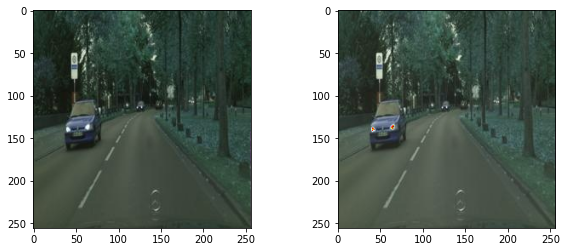

In [34]:
def aug_channel_shift(img, value):
    value = int(random.uniform(-value, value))
    img = img + value
    
    img[:,:,:][img[:,:,:]>255]  = 255
    img[:,:,:][img[:,:,:]<0]  = 0
    img = img.astype(np.uint8)
    
    return img


origin = labels[0]
img = channel_shift(origin, 80)

imshow_compare(origin, img)


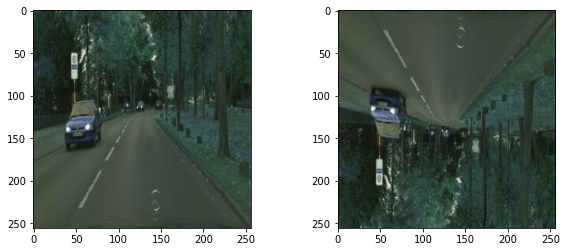

In [17]:
def aug_vertical_flip(img, flag=True):
        return cv2.flip(img, 0)

    
origin = labels[0]
img = vertical_flip(origin)

imshow_compare(origin, img)


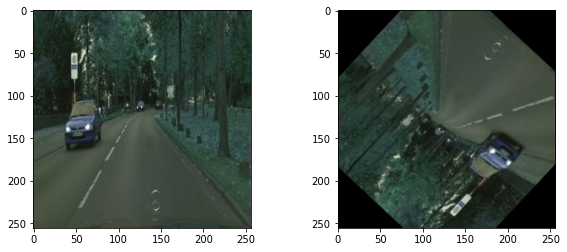

In [30]:
def aug_rotate(image, angle=180):
    angle = int(random.uniform(-angle, angle))
    h, w = image.shape[:2]
    M = cv2.getRotationMatrix2D((int(w/2), int(h/2)), angle, 1)
    img = cv2.warpAffine(image, M, (w, h))
    return img


origin = labels[0]
img = aug_rotate(origin)

imshow_compare(origin, img)


### 3.2. Apply Augmentation methods

In [ ]:

methods = 

for label, images in zip(labels, images):
    

In [14]:
@tf.function()
def random_jitter(input_image, real_image):
  # Resizing to 286x286
  input_image, real_image = resize(input_image, real_image, 286, 286)

  # Random cropping back to 256x256
  input_image, real_image = random_crop(input_image, real_image)

  if tf.random.uniform(()) > 0.5:
    # Random mirroring
    input_image = tf.image.flip_left_right(input_image)
    real_image = tf.image.flip_left_right(real_image)

  return input_image, real_image

사전 처리된 출력 중 일부를 검사할 수 있습니다.

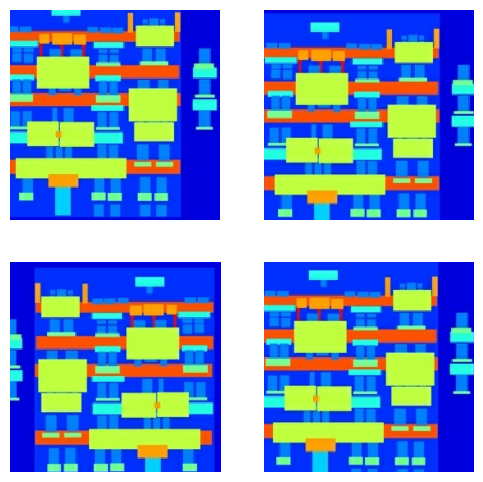

In [15]:
plt.figure(figsize=(6, 6))
for i in range(4):
  rj_inp, rj_re = random_jitter(inp, re)
  plt.subplot(2, 2, i + 1)
  plt.imshow(rj_inp / 255.0)
  plt.axis('off')
plt.show()

로드 및 사전 처리가 작동하는지 확인했으므로 훈련 및 테스트세트를 로드하고 사전 처리하는 몇 가지 도우미 함수를 정의해 보겠습니다.

In [16]:
def load_image_train(image_file):
  input_image, real_image = load(image_file)
  input_image, real_image = random_jitter(input_image, real_image)
  input_image, real_image = normalize(input_image, real_image)

  return input_image, real_image

In [17]:
def load_image_test(image_file):
  input_image, real_image = load(image_file)
  input_image, real_image = resize(input_image, real_image,
                                   IMG_HEIGHT, IMG_WIDTH)
  input_image, real_image = normalize(input_image, real_image)

  return input_image, real_image

## `tf.data`로 입력 파이프라인 구축하기

In [18]:
train_dataset = tf.data.Dataset.list_files(str(PATH / 'train/*.jpg'))
train_dataset = train_dataset.map(load_image_train,
                                  num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE)

In [19]:
try:
  test_dataset = tf.data.Dataset.list_files(str(PATH / 'test/*.jpg'))
except tf.errors.InvalidArgumentError:
  test_dataset = tf.data.Dataset.list_files(str(PATH / 'val/*.jpg'))
test_dataset = test_dataset.map(load_image_test)
test_dataset = test_dataset.batch(BATCH_SIZE)

## 생성기 구축하기

pix2pix cGAN 생성기는 *수정된* [U-Net](https://arxiv.org/abs/1505.04597){:.external}입니다. U-Net은 인코더(다운샘플러)와 디코더(업샘플러)로 구성됩니다. [이미지 분할](../images/segmentation.ipynb) 튜토리얼과 [U-Net 프로젝트 웹사이트](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/){:.external}에서 자세한 내용을 알아볼 수 있습니다.

- 인코더의 각 블록은 다음과 같습니다: 컨볼루션 -&gt; 배치 정규화 -&gt; 누출이 있는 ReLU
- 디코더의 각 블록은 다음과 같습니다: 전치된 컨볼루션 -&gt; 배치 정규화 -&gt; 드롭아웃(처음 3개 블록에 적용됨) -&gt; ReLU
- 인코더와 디코더 사이에는 건너뛰기 연결이 있습니다(U-Net에서와 같이).

다운샘플러(인코더) 정의:

In [20]:
OUTPUT_CHANNELS = 3

In [21]:
def downsample(filters, size, apply_batchnorm=True):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

  if apply_batchnorm:
    result.add(tf.keras.layers.BatchNormalization())

  result.add(tf.keras.layers.LeakyReLU())

  return result

In [22]:
down_model = downsample(3, 4)
down_result = down_model(tf.expand_dims(inp, 0))
print (down_result.shape)

(1, 128, 128, 3)


업샘플러(디코더) 정의:

In [23]:
def upsample(filters, size, apply_dropout=False):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))

  result.add(tf.keras.layers.BatchNormalization())

  if apply_dropout:
      result.add(tf.keras.layers.Dropout(0.5))

  result.add(tf.keras.layers.ReLU())

  return result

In [24]:
up_model = upsample(3, 4)
up_result = up_model(down_result)
print (up_result.shape)

(1, 256, 256, 3)


다운샘플러와 업샘플러로 생성기를 정의합니다.

In [25]:
def Generator():
  inputs = tf.keras.layers.Input(shape=[256, 256, 3])

  down_stack = [
    downsample(64, 4, apply_batchnorm=False),  # (batch_size, 128, 128, 64)
    downsample(128, 4),  # (batch_size, 64, 64, 128)
    downsample(256, 4),  # (batch_size, 32, 32, 256)
    downsample(512, 4),  # (batch_size, 16, 16, 512)
    downsample(512, 4),  # (batch_size, 8, 8, 512)
    downsample(512, 4),  # (batch_size, 4, 4, 512)
    downsample(512, 4),  # (batch_size, 2, 2, 512)
    downsample(512, 4),  # (batch_size, 1, 1, 512)
  ]

  up_stack = [
    upsample(512, 4, apply_dropout=True),  # (batch_size, 2, 2, 1024)
    upsample(512, 4, apply_dropout=True),  # (batch_size, 4, 4, 1024)
    upsample(512, 4, apply_dropout=True),  # (batch_size, 8, 8, 1024)
    upsample(512, 4),  # (batch_size, 16, 16, 1024)
    upsample(256, 4),  # (batch_size, 32, 32, 512)
    upsample(128, 4),  # (batch_size, 64, 64, 256)
    upsample(64, 4),  # (batch_size, 128, 128, 128)
  ]

  initializer = tf.random_normal_initializer(0., 0.02)
  last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                         strides=2,
                                         padding='same',
                                         kernel_initializer=initializer,
                                         activation='tanh')  # (batch_size, 256, 256, 3)

  x = inputs

  # Downsampling through the model
  skips = []
  for down in down_stack:
    x = down(x)
    skips.append(x)

  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    x = tf.keras.layers.Concatenate()([x, skip])

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

생성기 모델 아키텍처 시각화:

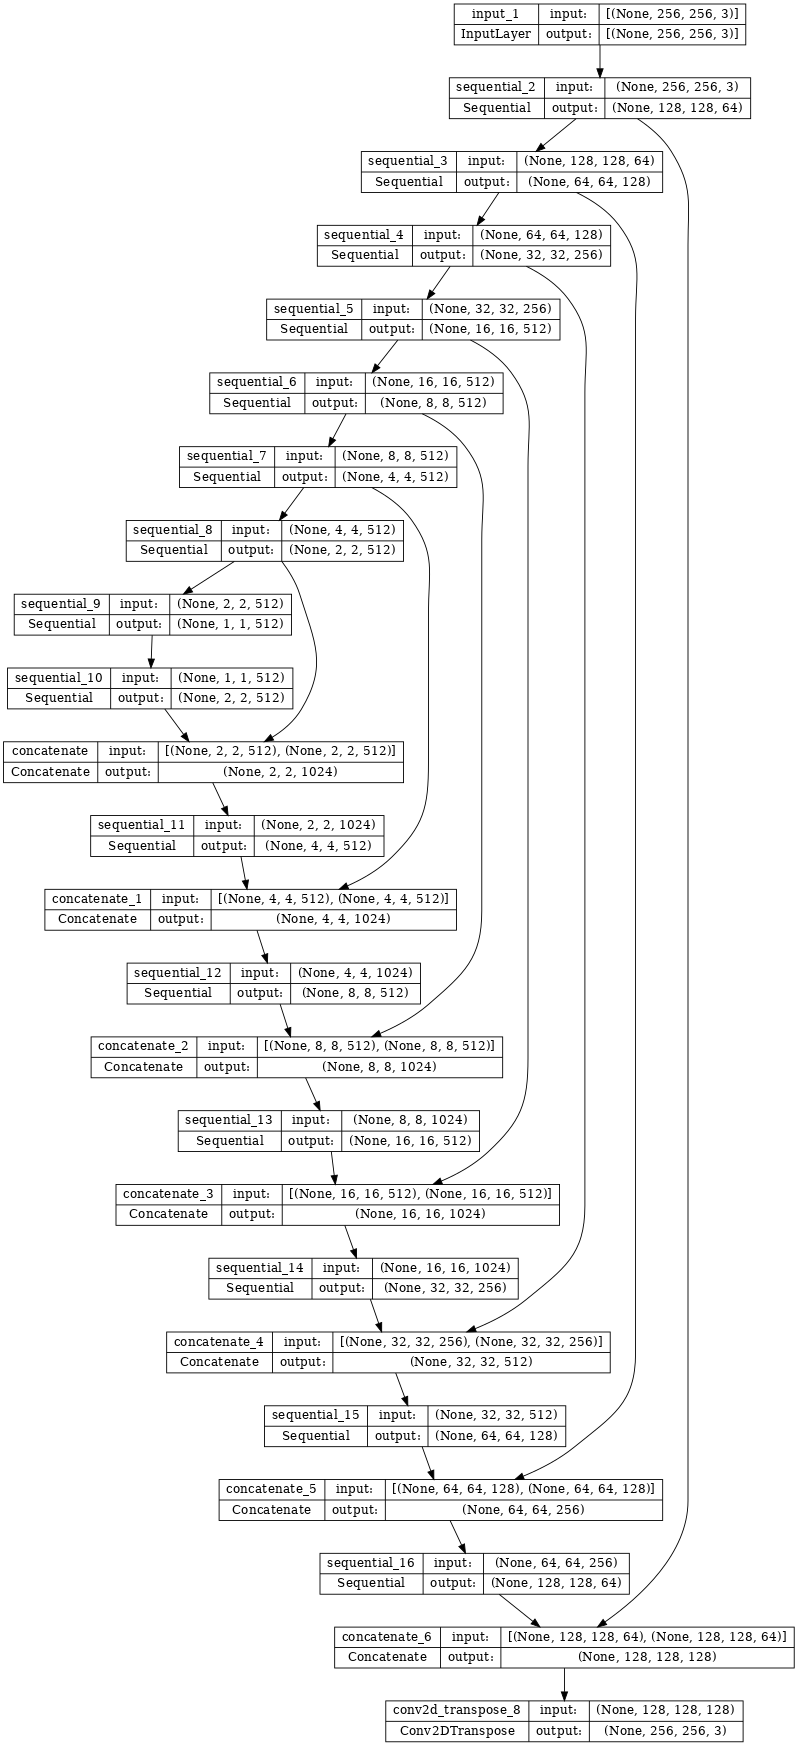

In [26]:
generator = Generator()
tf.keras.utils.plot_model(generator, show_shapes=True, dpi=64)

생성기 테스트:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


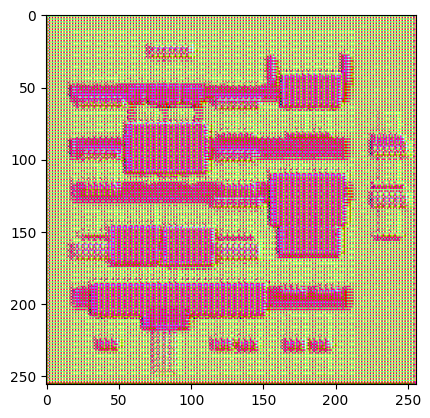

In [27]:
gen_output = generator(inp[tf.newaxis, ...], training=False)
plt.imshow(gen_output[0, ...])

### 생성기 손실 정의하기

GAN은 데이터에 적응하는 손실을 학습하는 반면 cGAN은 [pix2pix 논문](https://arxiv.org/abs/1611.07004){:.external}에 설명된 대로 네트워크 출력 및 대상 이미지와 다른 가능한 구조에 불이익을 주는 구조화된 손실을 학습합니다.

- 생성기 손실은 생성된 이미지와 **1로 구성된 배열**의 시그모이드 교차 엔트로피 손실입니다.
- pix2pix 논문에는 생성된 이미지와 대상 이미지 간의 MAE(평균 절대 오차)인 L1 손실도 언급되어 있습니다.
- 이를 통해 생성된 이미지가 대상 이미지와 구조적으로 유사해질 수 있습니다.
- 총 생성기 손실을 계산하는 공식은 `gan_loss + LAMBDA * l1_loss`이고 여기서 `LAMBDA = 100`입니다. 이 값은 논문 저자가 결정했습니다.

In [28]:
LAMBDA = 100

In [29]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [30]:
def generator_loss(disc_generated_output, gen_output, target):
  gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

  # Mean absolute error
  l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

  total_gen_loss = gan_loss + (LAMBDA * l1_loss)

  return total_gen_loss, gan_loss, l1_loss

생성기의 훈련 절차는 다음과 같습니다.

![발전기 업데이트 이미지](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/generative/images/gen.png?raw=1)


## 판별자 구축하기

pix2pix cGAN의 판별자는 컨볼루셔널 PatchGAN 분류기로, <a>pix2pix 논문</a>{:.external}에 설명된 대로 각 이미지 <em>패치</em>가 실제인지 아닌지를 분류하려고 합니다.

- 판별자의 각 블록은 다음과 같습니다: 컨볼루션 -&gt; 배치 정규화 -&gt; 누출이 있는 ReLU
- 마지막 레이어 이후의 출력 형상은 `(batch_size, 30, 30, 1)`입니다.
- 출력의 각 `30 x 30` 이미지 패치는 입력 이미지의 `70 x 70` 부분을 분류합니다.
- 판별자는 2개의 입력을 수신합니다.
    - 진짜로 분류해야 하는 입력 이미지 및 대상 이미지
    - 가짜로 분류해야 하는 입력 이미지와 생성된 이미지(생성기의 출력)
    - `tf.concat([inp, tar], axis=-1)`을 사용하여 이 2개의 입력을 함께 연결

판별자를 정의하겠습니다.

In [31]:
def Discriminator():
  initializer = tf.random_normal_initializer(0., 0.02)

  inp = tf.keras.layers.Input(shape=[256, 256, 3], name='input_image')
  tar = tf.keras.layers.Input(shape=[256, 256, 3], name='target_image')

  x = tf.keras.layers.concatenate([inp, tar])  # (batch_size, 256, 256, channels*2)

  down1 = downsample(64, 4, False)(x)  # (batch_size, 128, 128, 64)
  down2 = downsample(128, 4)(down1)  # (batch_size, 64, 64, 128)
  down3 = downsample(256, 4)(down2)  # (batch_size, 32, 32, 256)

  zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3)  # (batch_size, 34, 34, 256)
  conv = tf.keras.layers.Conv2D(512, 4, strides=1,
                                kernel_initializer=initializer,
                                use_bias=False)(zero_pad1)  # (batch_size, 31, 31, 512)

  batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

  leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

  zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)  # (batch_size, 33, 33, 512)

  last = tf.keras.layers.Conv2D(1, 4, strides=1,
                                kernel_initializer=initializer)(zero_pad2)  # (batch_size, 30, 30, 1)

  return tf.keras.Model(inputs=[inp, tar], outputs=last)

판별자 모델 아키텍처 시각화:

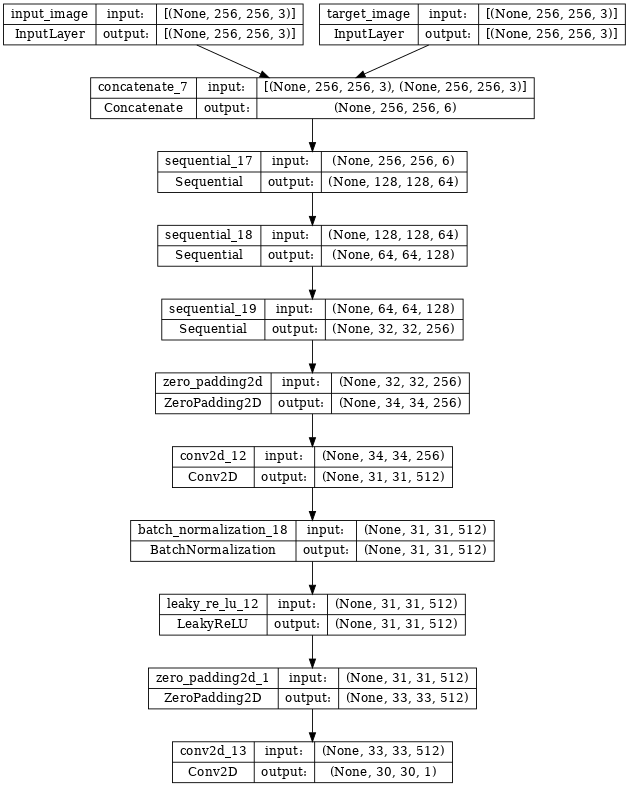

In [32]:
discriminator = Discriminator()
tf.keras.utils.plot_model(discriminator, show_shapes=True, dpi=64)

판별자 테스트:

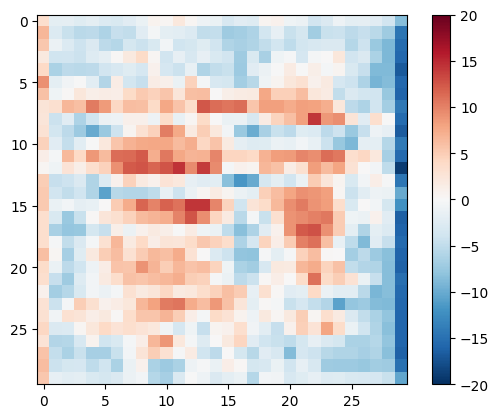

In [33]:
disc_out = discriminator([inp[tf.newaxis, ...], gen_output], training=False)
plt.imshow(disc_out[0, ..., -1], vmin=-20, vmax=20, cmap='RdBu_r')
plt.colorbar()

### 판별자 손실 정의하기

- `discriminator_loss` 함수는 **진짜 이미지**와 **생성된 이미지**의 두 입력을 받습니다.
- `real_loss`는 **진짜 이미지** 및 **1의 배열(실제 이미지이기 때문에)**의 시그모이드 교차 엔트로피 손실입니다.
- `generated_loss`는 **생성된 이미지** 및 **0의 배열(가짜 이미지이기 때문에)**의 시그모이드 교차 엔트로피 손실입니다.
- `total_loss`는 `real_loss`와 `generated_loss`의 합계입니다.

In [34]:
def discriminator_loss(disc_real_output, disc_generated_output):
  real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

  generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss

판별자의 훈련 절차는 다음과 같습니다.

아키텍처와 하이퍼파라미터에 대한 자세한 내용은 [pix2pix 논문](https://arxiv.org/abs/1611.07004){:.external}을 참조하세요.

![판별 기 업데이트 이미지](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/generative/images/dis.png?raw=1)


## 옵티마이저 및 체크포인트 세이버 정의하기


In [35]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [36]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

## 이미지 생성하기

훈련 중에 일부 이미지를 플롯하는 함수를 작성합니다.

- 테스트세트에서 생성기로 이미지를 전달합니다.
- 그러면 생성기가 입력 이미지를 출력으로 변환합니다.
- 마지막 단계는 예측을 플로팅하는 것입니다. *자 보세요*!

참고: 테스트 데이터세트에서 모델을 실행하는 동안 배치 통계를 원하기 때문에 여기서 `training=True`는 의도적입니다. `training=False`를 사용하면 훈련 데이터세트에서 학습된 누적 통계를 얻게 되는데, 이것은 원하는 것이 아닙니다.

In [37]:
def generate_images(model, test_input, tar):
  prediction = model(test_input, training=True)
  plt.figure(figsize=(15, 15))

  display_list = [test_input[0], tar[0], prediction[0]]
  title = ['Input Image', 'Ground Truth', 'Predicted Image']

  for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.title(title[i])
    # Getting the pixel values in the [0, 1] range to plot.
    plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis('off')
  plt.show()

함수 테스트:

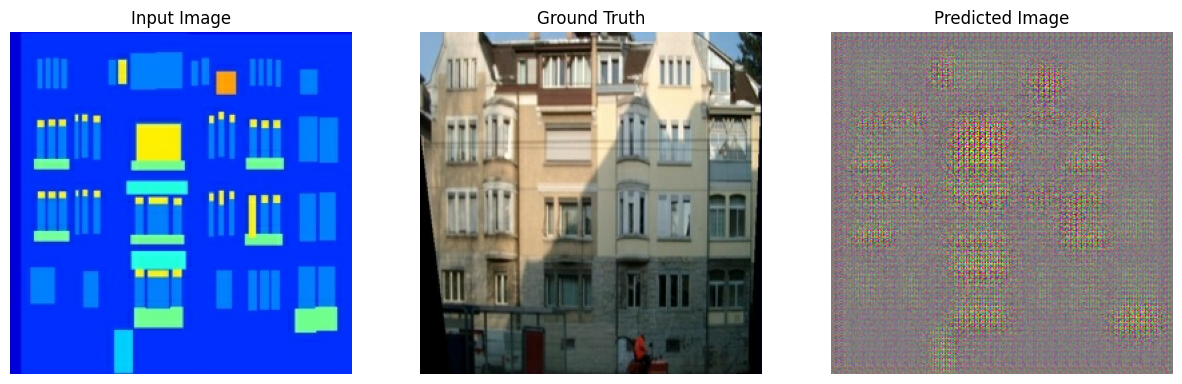

In [38]:
for example_input, example_target in test_dataset.take(1):
  generate_images(generator, example_input, example_target)

## 훈련하기

- 각 예제 입력에 대해 출력을 생성합니다.
- 판별자는 input_image 및 생성된 이미지를 첫 번째 입력으로 받습니다. 두 번째 입력은 input_image와 target_image입니다.
- 다음으로 생성기와 판별자 손실을 계산합니다.
- 그런 다음 생성기와 판별자 변수(입력) 모두에 대한 손실 기울기를 계산하고 이를 옵티마이저에 적용합니다.
- 마지막으로 TensorBoard에 손실을 기록합니다.

In [39]:
log_dir="logs/"

summary_writer = tf.summary.create_file_writer(
  log_dir + "fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

In [40]:
@tf.function
def train_step(input_image, target, step):
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    gen_output = generator(input_image, training=True)

    disc_real_output = discriminator([input_image, target], training=True)
    disc_generated_output = discriminator([input_image, gen_output], training=True)

    gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
    disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

  generator_gradients = gen_tape.gradient(gen_total_loss,
                                          generator.trainable_variables)
  discriminator_gradients = disc_tape.gradient(disc_loss,
                                               discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(generator_gradients,
                                          generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                              discriminator.trainable_variables))

  with summary_writer.as_default():
    tf.summary.scalar('gen_total_loss', gen_total_loss, step=step//1000)
    tf.summary.scalar('gen_gan_loss', gen_gan_loss, step=step//1000)
    tf.summary.scalar('gen_l1_loss', gen_l1_loss, step=step//1000)
    tf.summary.scalar('disc_loss', disc_loss, step=step//1000)

실제 훈련 루프. 이 튜토리얼은 둘 이상의 데이터세트를 실행할 수 있고 데이터세트의 크기가 크게 다르기 때문에 훈련 루프는 epoch 대신 단계적으로 작동하도록 설정됩니다.

- 스텝 수를 반복합니다.
- 10개 스텝마다 점(`.`)을 인쇄합니다.
- 1k 스텝마다: 디스플레이를 지우고 `generate_images`를 실행하여 진행 상황을 표시합니다.
- 5k 스텝마다: 체크포인트를 저장합니다.

In [41]:
def fit(train_ds, test_ds, steps):
  example_input, example_target = next(iter(test_ds.take(1)))
  start = time.time()

  for step, (input_image, target) in train_ds.repeat().take(steps).enumerate():
    if (step) % 1000 == 0:
      display.clear_output(wait=True)

      if step != 0:
        print(f'Time taken for 1000 steps: {time.time()-start:.2f} sec\n')

      start = time.time()

      generate_images(generator, example_input, example_target)
      print(f"Step: {step//1000}k")

    train_step(input_image, target, step)

    # Training step
    if (step+1) % 10 == 0:
      print('.', end='', flush=True)


    # Save (checkpoint) the model every 5k steps
    if (step + 1) % 5000 == 0:
      checkpoint.save(file_prefix=checkpoint_prefix)

이 훈련 루프는 훈련 진행 상황을 모니터링하기 위해 TensorBoard에서 볼 수 있는 로그를 저장합니다.

로컬 머신에서 작업하는 경우 별도의 TensorBoard 프로세스를 시작합니다. 노트북에서 작업할 때는 TensorBoard로 모니터링하기 위한 교육을 시작하기 전에 뷰어를 실행하세요.

뷰어를 시작하려면 다음을 코드 셀에 붙여 넣습니다.

In [ ]:
%load_ext tensorboard
%tensorboard --logdir {log_dir}

마지막으로 훈련 루프를 실행합니다.

Time taken for 1000 steps: 51.69 sec



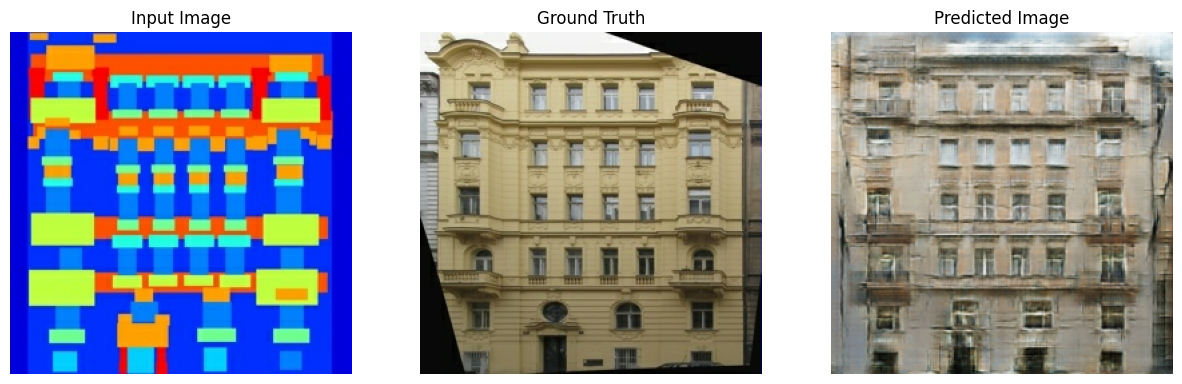

Step: 39k
....................................................................................................

In [42]:
fit(train_dataset, test_dataset, steps=40000)

TensorBoard 결과를 *공개적으로* 공유하려면 다음을 코드 셀에 복사하여 [TensorBoard.dev](https://tensorboard.dev/)에 로그를 업로드할 수 있습니다.

참고: 이를 위해 구글 계정이 필요합니다.

```
!tensorboard dev upload --logdir {log_dir}
```

주의: 이 명령은 종료되지 않습니다. 장기 실행되는 실험 결과를 지속적으로 업로드하도록 설계되었습니다. 데이터가 업로드되면 노트북 도구에서 "실행 중단" 옵션을 사용하여 실행을 중단시켜야 합니다.

[TensorBoard.dev](https://tensorboard.dev/experiment/lZ0C6FONROaUMfjYkVyJqw)에서 이 노트북의 [이전 실행 결과](https://tensorboard.dev/)를 볼 수 있습니다.

[TensorBoard.dev](https://tensorboard.dev){:.external}는 ML 실험을 호스팅 및 추적하고 모든 사람과 공유하기 위한 관리형 환경입니다.

`<iframe>`을 사용하여 인라인으로 포함할 수도 있습니다.

In [43]:
display.IFrame(
    src="https://tensorboard.dev/experiment/lZ0C6FONROaUMfjYkVyJqw",
    width="100%",
    height="1000px")

로그 해석은 단순 분류 또는 회귀 모델에 비해 GAN(또는 pix2pix와 같은 cGAN)을 훈련할 때 처리하기가 더 어렵습니다. 주목해야 할 사항:

- 생성기 또는 판별자 모델 모두가 "이기"지 않는다는 것을 확인합니다. `gen_gan_loss` 또는 `disc_loss`가 매우 낮아지면 이 모델이 다른 모델을 지배하고 있어 결합된 모델을 성공적으로 훈련하지 못하고 있음을 나타내는 것입니다.
- 값 `log(2) = 0.69`는 이러한 손실에 대한 좋은 기준점입니다. 이는 2의 퍼플렉시티를 나타내기 때문입니다. 판별자는 평균적으로 두 옵션에 대해 똑같이 불확실합니다.
- `disc_loss`의 경우 `0.69` 미만의 값은 판별자가 실제 이미지와 생성된 이미지의 결합된 세트에서 무작위보다 더 효과적임을 의미합니다.
- `gen_gan_loss`의 경우 `0.69` 미만의 값은 생성기가 판별자를 속이는 데 있어 무작위보다 더 효과적임을 의미합니다.
- 훈련이 진행됨에 따라 `gen_l1_loss`가 내려갑니다.

## 최신 체크포인트 복원 및 네트워크 테스트

In [44]:
!ls {checkpoint_dir}

checkpoint		    ckpt-5.data-00000-of-00001
ckpt-1.data-00000-of-00001  ckpt-5.index
ckpt-1.index		    ckpt-6.data-00000-of-00001
ckpt-2.data-00000-of-00001  ckpt-6.index
ckpt-2.index		    ckpt-7.data-00000-of-00001
ckpt-3.data-00000-of-00001  ckpt-7.index
ckpt-3.index		    ckpt-8.data-00000-of-00001
ckpt-4.data-00000-of-00001  ckpt-8.index
ckpt-4.index


In [45]:
# Restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

## 테스트세트를 사용하여 일부 이미지 생성하기

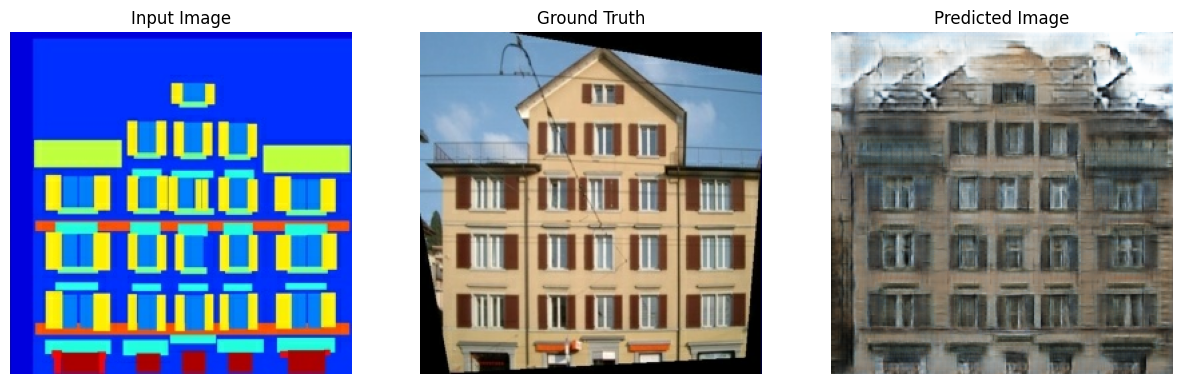

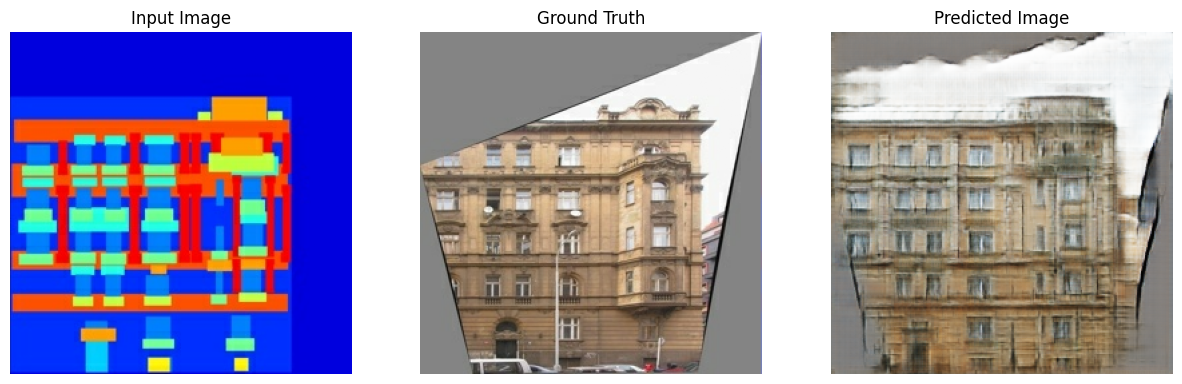

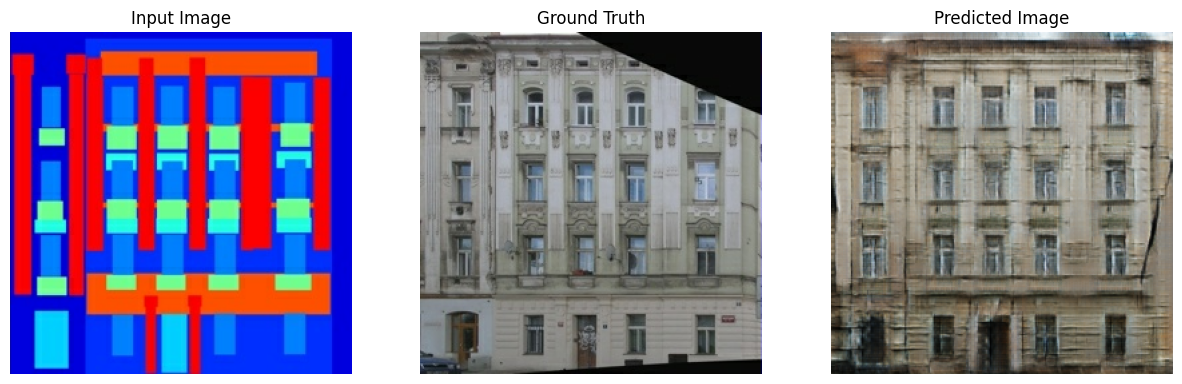

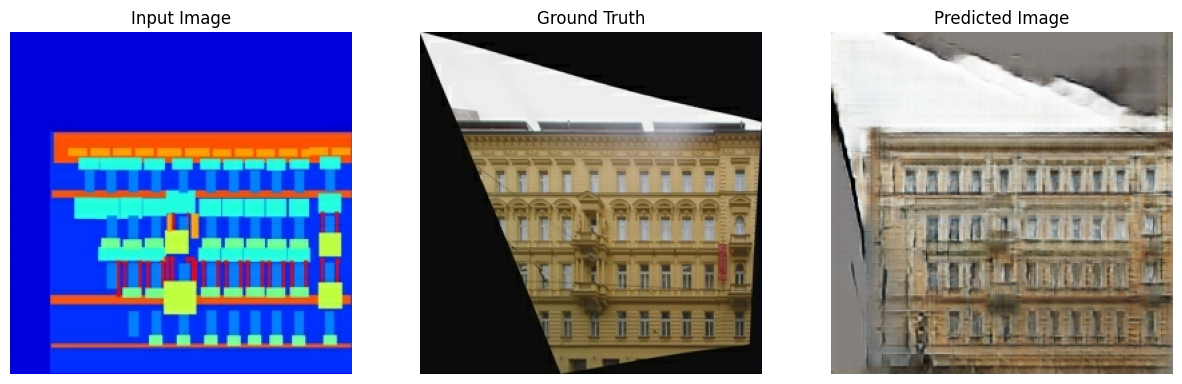

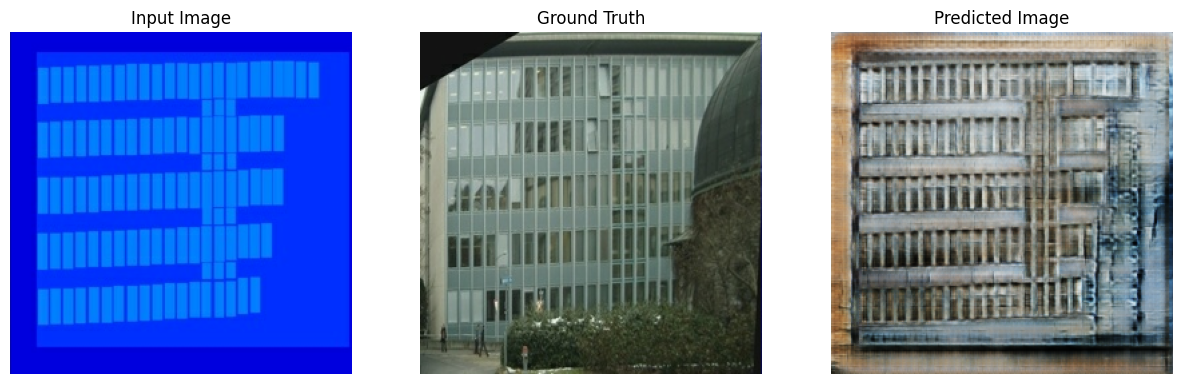

In [46]:
# Run the trained model on a few examples from the test set
for inp, tar in test_dataset.take(5):
  generate_images(generator, inp, tar)